# M5 Forecasting Accuracy Research
This is a continuation of my work on analyzing the sales data of Walmart's TX_1 store (Version 1 found here:https://www.kaggle.com/jimmyliuu/m5-forecast-accuracy-research-version-1). This week, I used a Long-Short Term Memory network and a simple Holt Linear Smoothing to forecast future food sales values of the store TX_1. 

I followed Jason Brownlee's "Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras" for the LSTM network. (found here: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

* I followed Benjamin Etienne's "Time Series in Python — Exponential Smoothing and ARIMA processes" for Holt Linear Smoothing. (found here: https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv


# Load in Datasets and Prep Datasets

In [2]:
CalendarDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv", header=0)
SalesDF=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv", header=0) #June 1st Dataset
CalendarDF['date'] = pd.to_datetime(CalendarDF.date)

TX_1_Sales = SalesDF[['TX_1' in x for x in SalesDF['store_id'].values]]
TX_1_Sales = TX_1_Sales.reset_index(drop = True)

# Generate MultiIndex for easier aggregration.
TX_1_Indexed = pd.DataFrame(TX_1_Sales.groupby(by = ['cat_id','dept_id','item_id']).sum())

# Aggregate total sales per day for each sales category
Food = pd.DataFrame(TX_1_Indexed.xs('FOODS').sum(axis = 0))
Hobbies = pd.DataFrame(TX_1_Indexed.xs('HOBBIES').sum(axis = 0))
Household = pd.DataFrame(TX_1_Indexed.xs('HOUSEHOLD').sum(axis = 0))

# Merge the aggregated sales data to the calendar dataframe based on date
CalendarDF = CalendarDF.merge(Food, how = 'left', left_on = 'd', right_on = Food.index)
CalendarDF = CalendarDF.rename(columns = {0:'Food'})
CalendarDF = CalendarDF.merge(Hobbies, how = 'left', left_on = 'd', right_on = Hobbies.index)
CalendarDF = CalendarDF.rename(columns = {0:'Hobbies'})
CalendarDF = CalendarDF.merge(Household, how = 'left', left_on = 'd', right_on = Household.index)
CalendarDF = CalendarDF.rename(columns = {0:'Household'})

# Drop dates with null sales data
CalendarDF = CalendarDF.drop(CalendarDF.index[1941:])
CalendarDF.reset_index(drop = True)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Food,Hobbies,Household
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1781.0,251.0,524.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1903.0,264.0,520.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1377.0,107.0,338.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1643.0,248.0,367.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1329.0,102.0,263.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,11616,Wednesday,5,5,2016,d_1937,NaN,NaN,NaN,NaN,0,0,0,1924.0,257.0,966.0
1937,2016-05-19,11616,Thursday,6,5,2016,d_1938,NaN,NaN,NaN,NaN,0,0,0,1764.0,229.0,755.0
1938,2016-05-20,11616,Friday,7,5,2016,d_1939,NaN,NaN,NaN,NaN,0,0,0,2384.0,281.0,999.0
1939,2016-05-21,11617,Saturday,1,5,2016,d_1940,NaN,NaN,NaN,NaN,0,0,0,2604.0,386.0,1177.0


# Building the LSTM model

In [3]:
# Modify Food data to feed into model

Food.index = CalendarDF.date
foodValues = Food.values

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
foodValues = scaler.fit_transform(foodValues)

# Train and Test datasets
foodTrain = foodValues[0:1899]
foodTest = foodValues[1899:1941]

In [4]:
# Create a function to convert array of values into dataset matrix
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
# Modify train and test datasets
look_back = 1
trainX, trainY = create_dataset(foodTrain, look_back)
testX, testY = create_dataset(foodTest, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [6]:
# Create and fit the LSTM network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Using TensorFlow backend.


Epoch 1/100
1897/1897 - 3s - loss: 0.0207
Epoch 2/100
1897/1897 - 3s - loss: 0.0088
Epoch 3/100
1897/1897 - 3s - loss: 0.0086
Epoch 4/100
1897/1897 - 3s - loss: 0.0086
Epoch 5/100
1897/1897 - 3s - loss: 0.0086
Epoch 6/100
1897/1897 - 3s - loss: 0.0085
Epoch 7/100
1897/1897 - 3s - loss: 0.0086
Epoch 8/100
1897/1897 - 3s - loss: 0.0085
Epoch 9/100
1897/1897 - 3s - loss: 0.0085
Epoch 10/100
1897/1897 - 3s - loss: 0.0085
Epoch 11/100
1897/1897 - 3s - loss: 0.0085
Epoch 12/100
1897/1897 - 3s - loss: 0.0085
Epoch 13/100
1897/1897 - 3s - loss: 0.0085
Epoch 14/100
1897/1897 - 3s - loss: 0.0085
Epoch 15/100
1897/1897 - 3s - loss: 0.0085
Epoch 16/100
1897/1897 - 3s - loss: 0.0085
Epoch 17/100
1897/1897 - 3s - loss: 0.0085
Epoch 18/100
1897/1897 - 3s - loss: 0.0085
Epoch 19/100
1897/1897 - 3s - loss: 0.0085
Epoch 20/100
1897/1897 - 3s - loss: 0.0085
Epoch 21/100
1897/1897 - 3s - loss: 0.0085
Epoch 22/100
1897/1897 - 3s - loss: 0.0085
Epoch 23/100
1897/1897 - 3s - loss: 0.0085
Epoch 24/100
1897/18

In [7]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Invert predictions to scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Train Score: 364.71 RMSE
Test Score: 342.60 RMSE


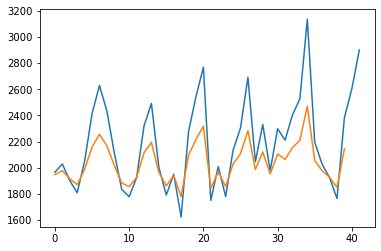

In [8]:
# Calculate root mean squared error
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Plot
import matplotlib.pyplot as plt

plt.plot(Food['20160411':'20160522'].values)
plt.plot(testPredict)
plt.show()

The LSTM model is able to accurately capture the trend. However, the predicted values are significantly off from the test values.

# Building the Holt Linear Smoothing model

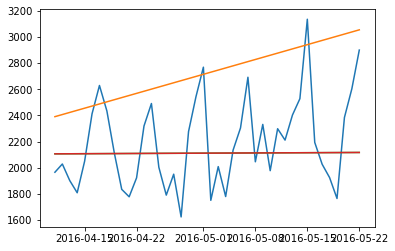

In [9]:
# Train and Test datasets
foodTrain = Food['20110129':'20160410']
foodTest = Food['20160411':'20160522']

# Simple linear smoothing model
from statsmodels.tsa.holtwinters import Holt

model = Holt(np.asarray(foodTrain.values))
model.index = pd.to_datetime(foodTrain.index)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.predict(1899, 1940)
pred1DF = pd.DataFrame(pred1, foodTest.index)

# Estimating the model paramaters by maximizing log values
fit2 = model.fit(optimized = True)
pred2 = fit2.predict(1899,1940)
pred2DF = pd.DataFrame(pred2, foodTest.index)

# Uses brute force optimizer to search for good starting values
fit3 = model.fit(use_brute = True)
pred3 = fit3.predict(1899,1940)
pred3DF = pd.DataFrame(pred3,foodTest.index)   

plt.plot(foodTest)
plt.plot(pred1DF)
plt.plot(pred2DF)
plt.plot(pred3DF)

plt.show()

The Holt-Winters Simple Linear Smoothing does not account for seasonality and mearly predicts linear trend based on training values. The orange line uses the smoothing level of .3 and smoothing slope of .05 to predict the trend (linearly increasing). However, the optimized and brute force parameters automatically create the model parameters and therefore generate a better model of estimating trend. The optimized and brute force parameters returned around the same predicition (shown by the red line which is overlapping another line). This Holt-Winters model does not capture seasonality and predicts that sales will fluctuate around an average near 2100.